In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [3]:
learning_rate = 2e-4
noise_dim = 32
image_dim = 28 * 28 * 1 
batch_size = 32
num_epochs = 25

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim, image_dim):
        super(Generator,self).__init__()
        self.linear1 = nn.Linear(noise_dim, 128)
        self.relu = nn.LeakyReLU(0.01)
        self.linear2 = nn.Linear(128, image_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.tanh(out)
        return out
    
    

In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_image):
        super(Discriminator,self).__init__()
        self.linear1 = nn.Linear(in_image, 64)
        self.relu = nn.LeakyReLU(0.01)
        self.linear2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out


In [6]:
discriminator = Discriminator(image_dim)
generator = Generator(noise_dim, image_dim)
noise = torch.randn((batch_size, noise_dim))

In [7]:
tf = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,), (0.5,)),]
)
ds = torchvision.datasets.MNIST(root="dataset/", transform=tf, download=True)
loader = data.DataLoader(ds, batch_size=batch_size, shuffle=True)

(-0.5, 241.5, 121.5, -0.5)

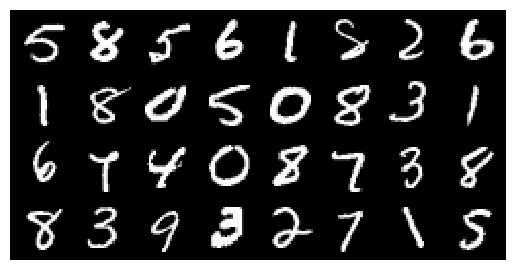

In [8]:
real_sample = iter(loader)
real_sample = next(real_sample)[0]
img_grid_real = torchvision.utils.make_grid(real_sample, normalize=True)
npgrid = img_grid_real.cpu().numpy()
plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
plt.axis('off')

In [9]:
opt_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate)
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [10]:
for epoch in range(num_epochs):
    for id, (training_sample, _) in enumerate(loader):
        training_sample = training_sample.view(-1, 784)
        batch_size = training_sample.shape[0]

        ### Training the Discriminator
        noise = torch.randn(batch_size, noise_dim)
        fake_sample = generator(noise)
        disc_realSample = discriminator(training_sample).view(-1)
        lossD_realSample = criterion(disc_realSample, torch.ones_like(disc_realSample))
        disc_fakeSample = discriminator(fake_sample).view(-1)
        lossD_fakeSample = criterion(disc_fakeSample, torch.zeros_like(disc_fakeSample)) 
        lossD = (lossD_realSample + lossD_fakeSample) / 2
        discriminator.zero_grad()
        #we are trying to minimize the total classification error
        lossD.backward(retain_graph=True)
        opt_discriminator.step()

        ### Training the Generator
        lossD_fakeSample = discriminator(fake_sample).view(-1)
        lossG = criterion(lossD_fakeSample, torch.ones_like(lossD_fakeSample))#we are trying to maximize the error of classification of fake image by the discriminator
        generator.zero_grad()
        lossG.backward()
        opt_generator.step()

        if id == 0:
            print( "Epoch: {epoch} \t Discriminator Loss: {lossD} Generator Loss: {lossG}".format( epoch=epoch, lossD=lossD, lossG=lossG))

Epoch: 0 	 Discriminator Loss: 0.6551536917686462 Generator Loss: 0.7541566491127014
Epoch: 1 	 Discriminator Loss: 0.27602100372314453 Generator Loss: 1.5122158527374268
Epoch: 2 	 Discriminator Loss: 0.7224582433700562 Generator Loss: 0.7773756980895996
Epoch: 3 	 Discriminator Loss: 0.7056373953819275 Generator Loss: 0.8564741611480713
Epoch: 4 	 Discriminator Loss: 0.5460480451583862 Generator Loss: 0.9644306898117065
Epoch: 5 	 Discriminator Loss: 0.4421822428703308 Generator Loss: 1.031524658203125
Epoch: 6 	 Discriminator Loss: 0.5351520776748657 Generator Loss: 1.3404262065887451
Epoch: 7 	 Discriminator Loss: 0.3968621492385864 Generator Loss: 1.2632354497909546
Epoch: 8 	 Discriminator Loss: 0.27899470925331116 Generator Loss: 1.6259300708770752
Epoch: 9 	 Discriminator Loss: 0.5150038599967957 Generator Loss: 1.3542554378509521
Epoch: 10 	 Discriminator Loss: 0.3950759470462799 Generator Loss: 1.4490227699279785
Epoch: 11 	 Discriminator Loss: 0.2819395363330841 Generator Lo

(3, 122, 242)


(-0.5, 241.5, 121.5, -0.5)

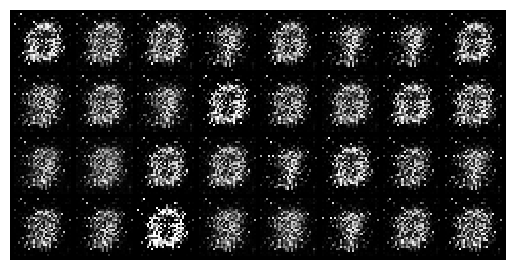

In [30]:
#generate fake numbers
noise = torch.randn(batch_size, noise_dim)
fake_sample = generator(noise).reshape(batch_size, 1, 28, 28)
img_grid_fake = torchvision.utils.make_grid(fake_sample, normalize=True)
npgrid = img_grid_fake.cpu().numpy()
print(npgrid.shape)
plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
plt.axis('off')